## 4. Evaluation

### 4.1 Importing the Library

In [ ]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

2025-11-20 15:04:40.524356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 15:04:40.524596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 15:04:40.557541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 15:04:41.246048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [5]:
DATA_DIR = "../dataset/processed/02_after_FE"
MODEL_DIR = "../models"

### 4.2 Load the Data

In [6]:
X_test_tfidf  = pickle.load(open(os.path.join(DATA_DIR, "X_test_tfidf.pkl"), "rb"))
X_test_pad    = pickle.load(open(os.path.join(DATA_DIR, "X_test_pad.pkl"), "rb"))
y_test        = pickle.load(open(os.path.join(DATA_DIR, "y_test.pkl"), "rb"))

y_test = np.array(y_test)

### 4.3 Check Array Dimension

In [7]:
# Data Type Conversion
X_test_pad   = np.array(X_test_pad, dtype='int32')     # Sequence
X_test_tfidf = np.array(X_test_tfidf, dtype='float32') # TFIDF
y_test       = np.array(y_test, dtype='float32')       # Label

# For Scikit-learn (Random Forest)
y_test_sklearn = y_test.astype(int).ravel()

print("Data types converted successfully.")

Data types converted successfully.


### 4.4 Load Models

In [8]:
rf_model     = pickle.load(open(os.path.join(MODEL_DIR, "rf_model.pkl"), "rb"))
lstm_model   = load_model(os.path.join(MODEL_DIR, "lstm_model.keras"))
bilstm_model = load_model(os.path.join(MODEL_DIR, "bilstm_model.keras"))

E0000 00:00:1763625881.504592   88142 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763625881.518561   88142 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 4.5 Evaluating Function

In [9]:
def evaluate_model_metrics(y_true, y_pred_binary, y_pred_proba):
    """Menghitung metrik evaluasi utama."""
    
    acc = accuracy_score(y_true, y_pred_binary)
    prec = precision_score(y_true, y_pred_binary, zero_division=0, pos_label=1)
    rec = recall_score(y_true, y_pred_binary, zero_division=0, pos_label=1)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0, pos_label=1)
    
    return {
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
    }

def round_metrics(metrics_dict):
    return {k: round(v, 4) for k, v in metrics_dict.items()}

### 4.6 Predicting and Evaluate All Models

In [10]:
scores = {}

# Random Forest
rf_pred_proba = rf_model.predict_proba(X_test_tfidf)[:, 1] 
rf_pred_binary = rf_model.predict(X_test_tfidf) 
scores['Random Forest + TF-IDF'] = round_metrics(
    evaluate_model_metrics(y_test_sklearn, rf_pred_binary, rf_pred_proba)
)

#LSTM
lstm_pred_proba = lstm_model.predict([X_test_pad, X_test_tfidf], verbose=0).flatten() 
lstm_pred_binary = (lstm_pred_proba > 0.5).astype(int)
scores['LSTM + TF-IDF'] = round_metrics(
    evaluate_model_metrics(y_test_sklearn, lstm_pred_binary, lstm_pred_proba)
)

# BiLSTM
bilstm_pred_proba = bilstm_model.predict([X_test_pad, X_test_tfidf], verbose=0).flatten()
bilstm_pred_binary = (bilstm_pred_proba > 0.5).astype(int)
scores['BiLSTM + TF-IDF'] = round_metrics(
    evaluate_model_metrics(y_test_sklearn, bilstm_pred_binary, bilstm_pred_proba)
)


for model_name, metrics in scores.items():
    print(f"\n-{model_name}-")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished



-Random Forest + TF-IDF-
accuracy: 0.9713
precision: 0.7537
recall: 0.9387
f1: 0.8361

-LSTM + TF-IDF-
accuracy: 0.9761
precision: 0.8304
recall: 0.8712
f1: 0.8503

-BiLSTM + TF-IDF-
accuracy: 0.9852
precision: 0.9177
recall: 0.8896
f1: 0.9034


In [11]:
results_df = pd.DataFrame(scores).T 

results_df = results_df.rename_axis('Model')
results_df = results_df.reset_index() 

print("--- Comparison ---")
print(results_df.to_markdown(index=False, numalign="left", stralign="left"))

--- Comparison ---
| Model                  | accuracy   | precision   | recall   | f1     |
|:-----------------------|:-----------|:------------|:---------|:-------|
| Random Forest + TF-IDF | 0.9713     | 0.7537      | 0.9387   | 0.8361 |
| LSTM + TF-IDF          | 0.9761     | 0.8304      | 0.8712   | 0.8503 |
| BiLSTM + TF-IDF        | 0.9852     | 0.9177      | 0.8896   | 0.9034 |


### 4.7 Visualizing

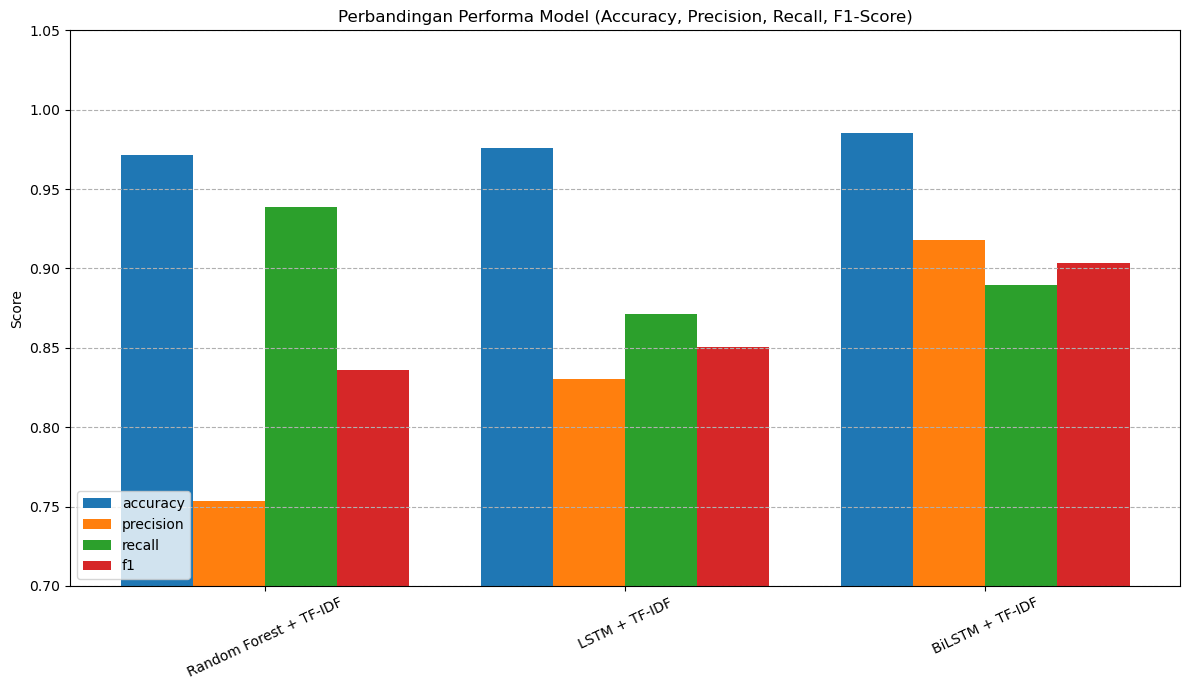

In [12]:
models = list(scores.keys())
metrics = ["accuracy", "precision", "recall", "f1"]

values = np.array([[scores[m][metric] for metric in metrics] for m in models])

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12, 7)) 

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, values[:, i], width, label=metric)

plt.xticks(x + width * 1.5, models, rotation=25) 
plt.ylabel("Score")
plt.ylim(0.70, 1.05)
plt.title("Perbandingan Performa Model (Accuracy, Precision, Recall, F1-Score)")
plt.legend(loc='lower left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
